In [1]:
from cond_rnn import ConditionalRNN
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
import pandas as pd
import math
import numpy as np

In [2]:
# import data
import pickle
with open("datasets2.pickle", "rb") as handle:
    input_data_shiftedy = pickle.load(handle)
# select only n, daily asthma visits and total, daily total AE visits, 
# comment out if including air pollution station data
first_col = input_data_shiftedy.n / input_data_shiftedy.total * 1000
input_data_shiftedy.insert(0, "prevalence", first_col)
input_data_shiftedy = input_data_shiftedy.drop(["n", "total", "y"], axis = 1)

# input_data_shiftedy = pd.concat([input_data_shiftedy.n.reset_index(drop = True), 
#                         input_data_shiftedy.total.reset_index(drop = True)], axis = 1)

# optional, select prevalence only

In [ ]:
input_data_shiftedy = input_data_shiftedy["prevalence"]

In [4]:
input_data_shiftedy.head()

0    7.133378
1    7.358462
2    5.601793
3    7.155907
4    9.012757
Name: prevalence, dtype: float64

In [13]:
int(len(input_data_shiftedy) * .8)

1861

In [14]:
# scaling fit with train-test split consideration to avoid data leakage
# may need verification
from sklearn.preprocessing import StandardScaler, Normalizer

# number of time steps for sequence learning
n_steps_x = 14
# number of time steps for sequence prediction
n_steps_y = 1

split_at = int(len(input_data_shiftedy) * .8)
val_split_at = int(len(input_data_shiftedy) * .9)


scaler = StandardScaler()
# if including air pollution data
# fit by training set only
input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:] = scaler.fit_transform(
    input_data_shiftedy.iloc[:(split_at + n_steps_x + n_steps_y),1:])
# only transform valid and testing sets
input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:] = scaler.transform(
    input_data_shiftedy.iloc[(split_at + n_steps_x + n_steps_y):,1:])



# optional for only prevalence scenario, no air pollution data

In [16]:
# if only prevalence data
input_data_shiftedy = input_data_shiftedy.values.reshape((input_data_shiftedy.shape[0], -1))
input_data_shiftedy[:(split_at + n_steps_x + n_steps_y)] = scaler.fit_transform(
    input_data_shiftedy[:(split_at + n_steps_x + n_steps_y)])
# only transform valid and testing sets
input_data_shiftedy[(split_at + n_steps_x + n_steps_y):] = scaler.transform(
    input_data_shiftedy[(split_at + n_steps_x + n_steps_y):])

In [17]:
def reshape_sliding1(X, num_steps_x = 2, num_steps_y = 2):
    X = pd.DataFrame(X)
    X_transformed = [np.array(X.shift(i)) for i in range(num_steps_x + num_steps_y)]
    X_transformed = np.dstack(X_transformed)
    
    # swap time steps and dimensionality axes
    X_transformed = np.swapaxes(X_transformed, 1, 2)
    # flip time steps axis
    X_transformed = np.flip(X_transformed, 1)
    X_transformed = X_transformed[(num_steps_x+num_steps_y - 1):]
    return X_transformed

In [18]:

input_data_shiftedy = reshape_sliding1(input_data_shiftedy, 
                                       num_steps_x = n_steps_x,
                                      num_steps_y = n_steps_y)

In [19]:
# train_test_split 

X_train = input_data_shiftedy[:split_at, :n_steps_x, :]
X_valid = input_data_shiftedy[split_at:val_split_at, :n_steps_x, :]
X_test = input_data_shiftedy[val_split_at:, :n_steps_x, :]

Y = np.empty((input_data_shiftedy.shape[0], n_steps_x))
for step_ahead in range(1, n_steps_y + 1):
    print(step_ahead, step_ahead + n_steps_x)
    Y = input_data_shiftedy[..., step_ahead:step_ahead + n_steps_x, 0]
Y_train = Y[:split_at]
Y_valid = Y[split_at:val_split_at]
Y_test = Y[val_split_at:]

1 15


In [20]:
Y_test.shape

(219, 14)

In [21]:
# # optional
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
# checking dimensionality
print(X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape)
assert X_train.shape[1:] == X_valid.shape[1:]
assert Y_train.shape[1:] == Y_valid.shape[1:]

(1861, 14, 1) (1861, 14) (233, 14, 1) (233, 14)


# modelling
1. as of 23rd aug 2022: rnn loss nan problem <br>
possible remedies: normalize data, regularization, increase batch size <br>
https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan <br>
2. as of 24th aug 2022: try to add overall AE visit to include hospital avoidance effect
3. as of 25th aug 2022: corrected reshaping problem, performance is still shit, try remove air pollution, try larger learning rate
4. as of 26th aug 2022: try seq2seq model, it worked 
5. from the results it seems most contributing factor is total AE trend 


In [23]:
from tensorflow import keras
import tensorflow as tf

In [24]:
optimizer = keras.optimizers.Adam(clipvalue = 1)

In [25]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [26]:
# simplified wavenet
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape = [X_train.shape[1], X_train.shape[2]]))
for rate in (1, 2, 4, 8, 16) * 2:
    model.add(keras.layers.Conv1D(filters = 100, kernel_size = 2, padding = "causal",
                                 activation = "relu", dilation_rate = rate))
model.add(keras.layers.Conv1D(filters = 1, kernel_size = 1))
# reshape 
# outputs_1d = Lambda(lambda x: tf.squeeze(x))(outputs)
# model.add(keras.layers.Lambda(lambda x: tf.squeeze(x)))
model.add(keras.layers.Lambda(lambda x: tf.reshape(x, [-1, 14])))
# model.add(keras.layers.Reshape((None, None), input_shape = model.output_shape))
model.compile(loss = "mse", optimizer = optimizer, metrics = [last_time_step_mse])

In [27]:
model.input_shape

(None, 14, 1)

In [28]:
history = model.fit(X_train, Y_train, epochs=30,
                    validation_data=(X_valid, Y_valid),
                    callbacks = [callback]
                   )

Epoch 1/30
59/59 [==============================] - 2s 17ms/step - loss: 0.6099 - last_time_step_mse: 0.5889 - val_loss: 0.4018 - val_last_time_step_mse: 0.3061
Epoch 2/30
59/59 [==============================] - 1s 14ms/step - loss: 0.4839 - last_time_step_mse: 0.4558 - val_loss: 0.3720 - val_last_time_step_mse: 0.3015
Epoch 3/30
59/59 [==============================] - 1s 13ms/step - loss: 0.4744 - last_time_step_mse: 0.4490 - val_loss: 0.3960 - val_last_time_step_mse: 0.3100
Epoch 4/30
59/59 [==============================] - 1s 13ms/step - loss: 0.4670 - last_time_step_mse: 0.4352 - val_loss: 0.3921 - val_last_time_step_mse: 0.3313
Epoch 5/30
59/59 [==============================] - 1s 18ms/step - loss: 0.4622 - last_time_step_mse: 0.4159 - val_loss: 0.3666 - val_last_time_step_mse: 0.3159
Epoch 6/30
59/59 [==============================] - 1s 13ms/step - loss: 0.4382 - last_time_step_mse: 0.3749 - val_loss: 0.4022 - val_last_time_step_mse: 0.3165
Epoch 7/30
59/59 [================

In [29]:
# inference 
import matplotlib.pyplot as plt

In [30]:
pred = model.predict(X_test)

In [31]:
assert pred.shape == Y_test.shape

In [32]:
print(pred.shape)

(219, 14)


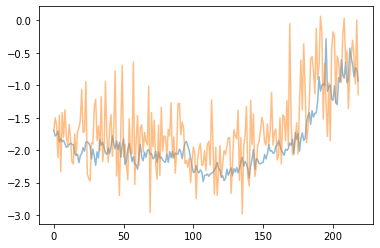

In [33]:
plt.plot(np.double(pred[:, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_test[:, -1]).flatten(), alpha = .5)

In [23]:
def last_time_step_mse_total(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1, -1], Y_pred[:, -1, -1])
last_time_step_mse_total(Y_test, pred)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [34]:
pred = model.predict(X_valid)

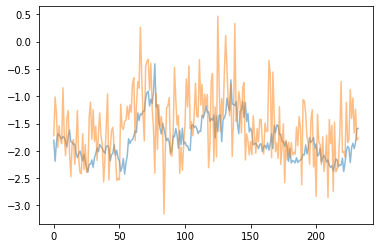

In [35]:
plt.plot(np.double(pred[:, -1]).flatten(), alpha = .5)
plt.plot(np.double(Y_valid[:, -1]).flatten(), alpha = .5)

In [26]:
pred.shape

(233, 14)

# shap value

In [27]:
import shap

/Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def f(X):
    return model.predict(X)[:, -1]

In [40]:
# explainer = shap.KernelExplainer(f, X_test[:50])

In [29]:
explainer = shap.DeepExplainer(model, X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [30]:
X_test[:50, -1, :].shape

(50, 92)

In [31]:
model.inputs

[<KerasTensor: shape=(None, 14, 92) dtype=float32 (created by layer 'input_1')>]

In [32]:
# https://github.com/slundberg/shap/issues/1226 the nonetype shape problem

In [33]:
shap_values = explainer.shap_values(X_test)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


StagingError: in user code:

    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/shap/explainers/_deep/deep_tf.py:252 grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:1090 gradient  **
        unconnected_gradients=unconnected_gradients)
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/imperative_grad.py:77 imperative_grad
        compat.as_str(unconnected_gradients.value))
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/eager/backprop.py:148 _gradient_function
        grad_fn = ops._gradient_registry.lookup(op_name)  # pylint: disable=protected-access
    /Users/ytf1997/miniconda3/envs/ML_learn/lib/python3.6/site-packages/tensorflow/python/framework/registry.py:100 lookup
        "%s registry has no entry for: %s" % (self._name, name))

    LookupError: gradient registry has no entry for: shap_BatchToSpaceND


In [46]:
X_test.shape

(219, 14, 92)